In [24]:
!pip install optuna

In [31]:
# ======================================================
# 📦 1. Imports
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


In [32]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [33]:
# ======================================================
# 📂 2. Load Data
# ======================================================
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
except FileNotFoundError:
    print("="*50)
    print("ERROR: 'train.xlsx' or 'test.csv' not found.")
    print("Please upload your files to the Colab session.")
    print("="*50)
    raise

train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)


✅ Train shape: (15533, 18)
✅ Test shape: (5225, 17)


In [34]:
# ======================================================
# 🧩 4. Feature Engineering
# ======================================================
# Apply to both train and test
for df in [train_df, test_df]:
    df['BMI'] = df['Weight'] / (df['Height']**2)
    # Add another potential feature
    df['Age_x_BMI'] = df['Age'] * df['BMI']



print("✅ Feature engineering complete (BMI, Age_x_BMI).")

✅ Feature engineering complete (BMI, Age_x_BMI).


/tmp/ipython-input-1263702147.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='BMI_Category', palette='viridis')


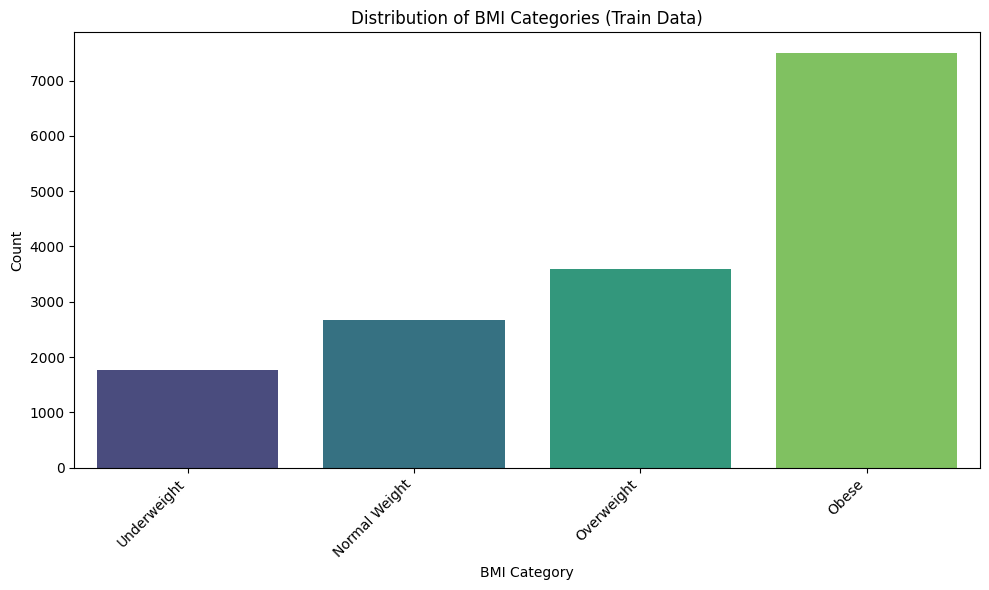

✅ BMI Category histogram created.


In [35]:
# ======================================================
# 📊 5. Data Visualization - BMI Distribution
# ======================================================
# Define BMI categories
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal Weight'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Apply the function to create a new column
train_df['BMI_Category'] = train_df['BMI'].apply(bmi_category)

# Order the categories for proper plotting
bmi_order = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
train_df['BMI_Category'] = pd.Categorical(train_df['BMI_Category'], categories=bmi_order, ordered=True)


# Create the histogram
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='BMI_Category', palette='viridis')
plt.title('Distribution of BMI Categories (Train Data)')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ BMI Category histogram created.")

In [36]:
# ======================================================
# 🧾 4. Split data into features and target
# ======================================================
X = train_df.drop(columns=['WeightCategory', 'id'])
y_strings = train_df['WeightCategory'] # Original string labels
test_ids = test_df['id']
X_test = test_df.drop(columns=['id'])

# --- UPDATED: Encode Target Variable 'y' ---
# XGBoost requires numeric labels. We save 'le' to decode later.
le = LabelEncoder()
y = le.fit_transform(y_strings) # 'y' is now an array of numbers [0, 1, 2...]
# --- End of Update ---

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
# Remove 'BMI_Category' from numeric columns as it's a string representation
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
if 'BMI_Category' in num_cols:
  num_cols.remove('BMI_Category')


print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Age_x_BMI']


In [37]:
# ======================================================
# 🔄 5. Train-test split for final evaluation
# ======================================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =============


In [38]:
# ======================================================
# ⚙️ 6. Preprocessing + Model Pipeline
# ======================================================
preprocessor = ColumnTransformer(
    transformers=[
        # Use OneHotEncoder for categorical columns
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        # Pass numeric columns through without changes
        ('num', 'passthrough', num_cols)
    ]
)

def create_pipeline(params=None):
    if params is None:
        params = {}
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y)), # Use the numeric 'y'
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42,
        **params
    )
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    return pipeline

In [39]:
# ======================================================
# 🧪 7. Hyperparameter Tuning (No Data Leakage)
# ======================================================
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
    }

    pipeline = create_pipeline(params)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    # Cross-validate on the training set (X_train, y_train)
    # y_train is now numeric, so this will work
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_te = y_train[train_idx], y_train[test_idx]

        pipeline.fit(X_tr, y_tr)
        preds = pipeline.predict(X_te)
        scores.append(accuracy_score(y_te, preds))

    return np.mean(scores)

print("🔍 Running Optuna tuning (no leakage)...")
# Suppress Optuna's trial logging for a cleaner output
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("✅ Best params:", study.best_params)

🔍 Running Optuna tuning (no leakage)...


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Best params: {'max_depth': 3, 'learning_rate': 0.04321338789982952, 'n_estimators': 591, 'subsample': 0.6570633972907176, 'colsample_bytree': 0.7896369245074647, 'min_child_weight': 6, 'gamma': 0.23926944367899652, 'reg_lambda': 0.9963553970854031, 'reg_alpha': 0.4422515549759468}


In [40]:
# ======================================================
# 🧠 8. Train Final Model with Best Params
# ======================================================
final_pipeline = create_pipeline(study.best_params)
# Train on the full training set
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC', 'MTRANS']),
                                                 ('num', 'passthrough',
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE', 'BMI',
                                                   'Age_x_BMI'])])),
                ('model',
                 XGBClassifier(base_sc...
                               gamma=0.23926944367899652, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04321338789982952, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=591, n_jobs=None, num_class=7, ...))])


🎯 Validation Accuracy: 0.9040875442549082

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.92      0.95      0.93       374
      Normal_Weight       0.88      0.90      0.89       469
     Obesity_Type_I       0.89      0.86      0.87       441
    Obesity_Type_II       0.96      0.97      0.96       481
   Obesity_Type_III       0.99      1.00      0.99       597
 Overweight_Level_I       0.82      0.75      0.78       369
Overweight_Level_II       0.80      0.84      0.82       376

           accuracy                           0.90      3107
          macro avg       0.89      0.89      0.89      3107
       weighted avg       0.90      0.90      0.90      3107



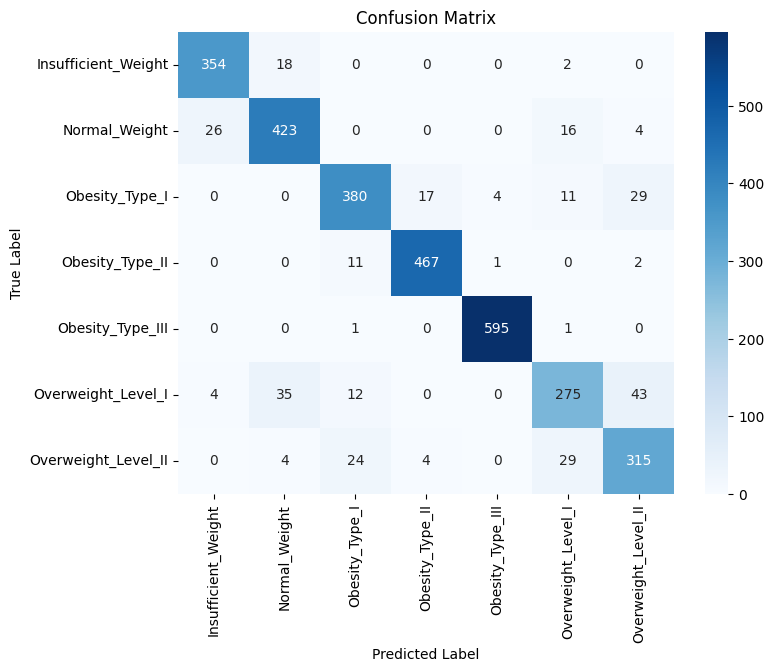

In [41]:
# 📊 9. Evaluate
# ======================================================
# Evaluate on the hold-out validation set
y_pred = final_pipeline.predict(X_val)
print("\n🎯 Validation Accuracy:", accuracy_score(y_val, y_pred))

# Decode y_val and y_pred for a readable classification report
y_val_labels = le.inverse_transform(y_val)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification Report:\n", classification_report(y_val_labels, y_pred_labels))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


<Figure size 800x600 with 0 Axes>

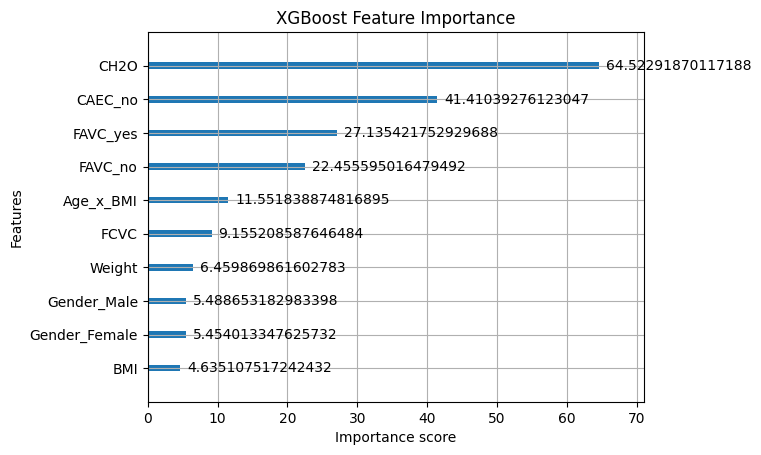

In [43]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
# Extract the XGBoost model from the pipeline
xgboost_model = final_pipeline.named_steps['model']

# Get feature names from the preprocessor
preprocessor = final_pipeline.named_steps['preprocessor']
# Get the one-hot encoded feature names
onehot_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
# Get the numeric feature names
numeric_features = num_cols
# Combine all feature names in the correct order
all_features = onehot_features + numeric_features

# Plot importance with real feature names
ax = plot_importance(xgboost_model, max_num_features=10, importance_type='gain')
plt.title("XGBoost Feature Importance")

# Get the indices of the top N features based on importance
top_n_indices = xgboost_model.feature_importances_.argsort()[-10:][::-1] # Get top 10 indices in descending order

# Get the corresponding feature names
top_n_feature_names = [all_features[i] for i in top_n_indices]

# Manually set the y-tick labels
ax.set_yticklabels(top_n_feature_names)

plt.show()

In [ ]:
# ======================================================
# 📤 10. Predict on Test Data (Safe Transformation)
# ======================================================
# Predict on the test set
test_pred_numeric = final_pipeline.predict(X_test)

# --- UPDATED: Decode Predictions ---
# Convert the numeric predictions [0, 1, 2...] back to strings
test_pred_labels = le.inverse_transform(test_pred_numeric)
# --- End of Update ---

submission = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_pred_labels # Use the readable string labels
})
submission.to_csv('submissio.csv', index=False)
print("✅ submission.csv created successfully!")

✅ submission.csv created successfully!


In [ ]:
# Step 12: Download file
from google.colab import files
files.download('submissio.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>